In [ ]:
#default_exp causal_model

# Causal Model
> Implementing instrumental variable and backdoor criteria plus propensity and regression methods

**Notes**

* Causal Bayesian Networkx: [here](http://conference.scipy.org/proceedings/scipy2015/pdfs/mike_pacer.pdf)

dowhy > causal_model.py CausalModel > causal_graph.py CausalGraph

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import dowhy as dw
from typing import List, Union
import networkx as nx
import itertools
import sympy as sp
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
import numpy as np
from scipy import stats

In [ ]:
plt.style.use('bmh')

In [ ]:
treatments = ['v0', 'v1']
outcome = 'Y'
common_causes = ['W0']
effect_modifiers = ['E0']
instruments = []
observed_nodes = treatments + [outcome] + instruments + effect_modifiers + common_causes
add_unobserved_confounder = True
missing_nodes_as_confounders = True

In [ ]:
cg_ref = dw.causal_graph.CausalGraph(treatments,
                                 [outcome], graph=None,
                                 common_cause_names=common_causes,
                                 instrument_names=instruments,
                                 effect_modifier_names=effect_modifiers,
                                 observed_node_names=observed_nodes)

In [ ]:
cg_ref._graph.nodes(data=True)

NodeDataView({'v0': {'observed': 'yes'}, 'v1': {'observed': 'yes'}, 'Y': {'observed': 'yes'}, 'W0': {'observed': 'yes'}, 'E0': {'observed': 'yes'}, 'U': {'label': 'Unobserved Confounders', 'observed': 'no'}})

In [ ]:
#export
class CausalGraph:
    def __init__(self, treatments:List[str], outcome:str='Y', 
                 common_causes:List[str]=None, effect_modifiers:List[str]=None,
                 instruments:List[str]=None, observed_nodes:List[str]=None, 
                 missing_nodes_as_confounders:bool=False,
                 add_unobserved_confounder:bool=True):
        if common_causes is None: common_causes = []
        if effect_modifiers is None: effect_modifiers = []
        if instruments is None: instruments = []
        if missing_nodes_as_confounders:
            all_passed_nodes = treatments + [outcome] + \
                common_causes + effect_modifiers + instruments
            missing_nodes = [node for node in all_passed_nodes if node not in observed_nodes]            
            common_causes = list(common_causes) + missing_nodes            
            
        self.g = self.create_nx_digraph(treatments, outcome, 
                                        common_causes, instruments, 
                                        effect_modifiers, add_unobserved_confounder)
        
    @staticmethod
    def create_nx_digraph(treatments:List[str], outcome:str, common_causes:List[str], 
                          instruments:List[str], effect_modifiers:List[str],
                          add_unobserved_confounder:bool=False):
        g = nx.DiGraph()
        g.add_edges_from([(treatment, outcome) for treatment in treatments])
        g.add_edges_from([(common_cause, treatment) 
                          for common_cause, treatment in itertools.product(common_causes, treatments)])
        g.add_edges_from([(common_cause, outcome) 
                          for common_cause in common_causes])
        g.add_edges_from([(effect_modifier, outcome) for effect_modifier in effect_modifiers])
        g.add_edges_from([(instrument, treatment) for instrument, treatment in itertools.product(instruments, treatments)])
        nx.set_node_attributes(g, True, 'observed')
        if add_unobserved_confounder:
            g.add_node('U', observed=False)
            g.add_edges_from([('U', treatment) for treatment in treatments])
            g.add_edge('U', outcome)
            
        return g


In [ ]:
cg = CausalGraph(treatments=treatments, outcome=outcome, common_causes=common_causes,
                 effect_modifiers=effect_modifiers, observed_nodes=observed_nodes,
                 missing_nodes_as_confounders=missing_nodes_as_confounders,
                 add_unobserved_confounder=add_unobserved_confounder)

In [ ]:
cg.g.nodes['U']['observed']

False

In [ ]:
#export
def show_graph(g:nx.Graph, kind:str='spectral'):
    try:
        layout = getattr(nx, f'{kind}_layout')(g)
    except AttributeError as ae:
        raise AttributeError(f'No nx.{kind}_layout found')
    nx.draw(g, layout=layout, with_labels=True)

def view_graph(self, kind:str='spectral'): 
    show_graph(self.g, kind=kind)

CausalGraph.view_graph = view_graph

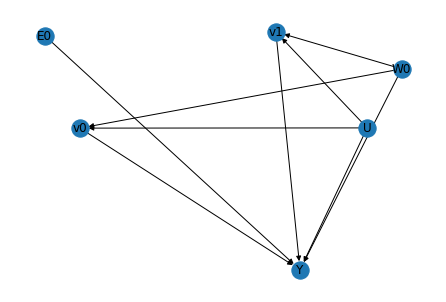

In [ ]:
cg.view_graph()

In [ ]:
#export
def get_ancestors(self, node:str, g:nx.DiGraph=None, 
                  parents_only:bool=False):
    if parents_only:
        f = self.g if g is None else g
        return f.predecessors(node)
    return nx.ancestors(self.g if g is None else g, node)

CausalGraph.get_ancestors = get_ancestors

In [ ]:
cg.get_ancestors('v0')

{'U', 'W0'}

In [ ]:
#hide
assert cg_ref.get_ancestors('v0') == cg.get_ancestors('v0')

In [ ]:
#export
def cut_edges(self, edges_to_cut:List[tuple]=None):
    if edges_to_cut is None: return None
    g_cut = self.g.copy()
    g_cut.remove_edges_from(edges_to_cut)
    return g_cut
        
CausalGraph.cut_edges = cut_edges

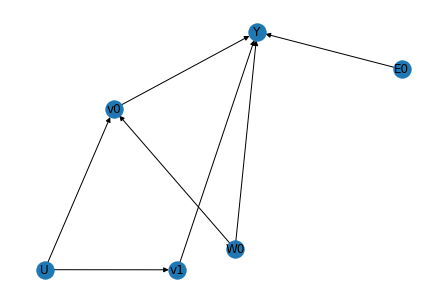

In [ ]:
g_cut = cg.cut_edges([('U','Y'), ('W0', 'v1')])
show_graph(g_cut)

In [ ]:
#hide
assert cg.cut_edges() is None

In [ ]:
#export
def get_causes(self, nodes:List[str], 
               edges_to_cut:List[tuple]=None):
    g_cut = self.cut_edges(edges_to_cut)
    causes = set()
    for node in nodes:
        causes.update(self.get_ancestors(node, g_cut))
    return causes

CausalGraph.get_causes = get_causes

In [ ]:
#hide
assert {'E0', 'U', 'W0', 'v0', 'v1'} == cg.get_causes(['Y'])
assert {'U', 'W0'} == cg.get_causes(['v0'])
assert cg_ref.get_causes(['Y']) == cg.get_causes(['Y'])
assert cg_ref.get_causes(['v0']) == cg.get_causes(['v0'])

In [ ]:
cg.get_causes(['v0'])

{'U', 'W0'}

In [ ]:
#export
def get_instruments(self, treatments:List[str], outcome:str):
    treatment_parents_edges = set()
    treatment_parents = set()
    for treatment in treatments:
        parents = self.get_ancestors(treatment, parents_only=True)
        treatment_parents.update(parents)
        treatment_parents_edges.update([(parent, treatment) 
                               for parent in parents])
    
    g_cut = self.cut_edges(treatment_parents_edges)
    
    outcome_ancestors = self.get_ancestors(outcome, g_cut)
    
    instruments_candidates = treatment_parents.difference(outcome_ancestors)
    
    descendants = set()
    for parent in outcome_ancestors:
        descendants.update(nx.descendants(g_cut, parent))
    instruments = instruments_candidates.difference(descendants)
    return instruments

CausalGraph.get_instruments = get_instruments

In [ ]:
cg.get_instruments(treatments, outcome)

In [ ]:
#hide
assert set(cg_ref.get_instruments(treatments, [outcome])) == set(cg.get_instruments(treatments, outcome))

In [ ]:
#export
def get_effect_modifiers(self, treatments:List[str], outcomes:List[str]):
    modifiers = set()
    for outcome in outcomes:
        modifiers.update(self.get_ancestors(outcome))
    modifiers = modifiers.difference(treatments)
    for treatment in treatments:
        modifiers = modifiers.difference(self.get_ancestors(treatment))
    return list(modifiers)
    
CausalGraph.get_effect_modifiers = get_effect_modifiers

In [ ]:
cg.get_effect_modifiers(treatments, [outcome])

['E0']

In [ ]:
#hide
assert set(cg_ref.get_effect_modifiers(treatments, [outcome])) == set(cg.get_effect_modifiers(treatments, [outcome])), f'{effect_modifiers} != {cg.get_effect_modifiers(treatments, [outcome])}'

In [ ]:
#export
class CausalModel:
    
    def __init__(self, treatments:List[str], outcome:str='Y',
                 common_causes:List[str]=None, effect_modifiers:List[str]=None,
                 instruments:List[str]=None, causal_graph_kwargs=None):
        if not causal_graph_kwargs: causal_graph_kwargs = dict()
        self.cg = CausalGraph(treatments, outcome, 
                              common_causes=common_causes,
                              effect_modifiers=effect_modifiers, 
                              instruments=instruments, 
                              **causal_graph_kwargs)
        self.treatments = treatments
        self.outcome = outcome
        self.common_causes = common_causes
        self.effect_modifiers = effect_modifiers
        self.instruments = instruments
        
    def identify_effect(self):
        pass
    def estimate_effect(self):
        pass
    def refute_estimate(self):
        pass

In [ ]:
treatments = ['v0', 'v1']
outcome = 'Y'
common_causes = ['W0']
effect_modifiers = ['E0']
instruments = []
observed_nodes = treatments + [outcome] + instruments + effect_modifiers
add_unobserved_confounder = True
missing_nodes_as_confounders = True

cg_kwargs = dict(
    missing_nodes_as_confounders=missing_nodes_as_confounders,
    add_unobserved_confounder=add_unobserved_confounder,
    observed_nodes=observed_nodes
)

In [ ]:
cm = CausalModel(treatments=treatments, outcome=outcome, common_causes=common_causes,
                 effect_modifiers=effect_modifiers,
                 causal_graph_kwargs=cg_kwargs)

In [ ]:
#export
def identify_effect(self, estimand_type:str='nonparametric-ate'):
    causes = {
        'treatments': self.cg.get_causes(self.treatments),
        'effects': self.cg.get_causes([self.outcome], 
                                      edges_to_cut=[(t, self.outcome) for t in self.treatments])
    }
    print(f'causes: {causes}')
    common_causes = causes['treatments'].intersection(causes['effects'])
    print(f'common causes: {common_causes}')
    
    instruments = self.cg.get_instruments(self.treatments, self.outcome)
    
    # constructing backdoor estimand
    backdoor = self.construct_backdoor(self.treatments, self.outcome,
                                       common_causes, estimand_type=estimand_type)
    print('Backdoor:', backdoor)
    
    # constructing instrumental variable estimand
    instrumental_variable = None
    if len(instruments) > 0:
        instrumental_variable = self.construct_instrumental_variable(treatments, outcome, instruments,
                                                                 estimand_type=estimand_type)
    
    print('Instrumental variable:', instrumental_variable)
    return {
        'observed_common_causes': common_causes,
        'backdoor': backdoor,
        'instrumental_variable': instrumental_variable
    }
    
def construct_backdoor(self, treatments:List[str], outcome:str, 
                       common_causes:List[str], 
                       estimand_type:str='nonparametric-ate'):
    
    if estimand_type != 'nonparametric-ate': raise NotImplementedError
    
    # treatment variables
    sym_treatments = sp.Array([sp.Symbol(treatment) for treatment in treatments])
    
    # outcome given common causes
    expr = f'{outcome} | {",".join(common_causes)}' \
        if len(common_causes) > 0 else outcome  
    
    # assigning a normal distribution to the outcome given common causes
    sym_mu = sp.Symbol("mu")                                                                           
    sym_sigma = sp.Symbol("sigma", positive=True)
    sym_outcome = sp.stats.Normal(expr, sym_mu, sym_sigma)
    # expected outcome given common causes
    sym_conditional_outcome = sp.stats.Expectation(sym_outcome) 
    
    # effect of treatment on outcome given common causes
    sym_effect = sp.Derivative(sym_conditional_outcome, sym_treatments) 
    return sym_effect

def construct_instrumental_variable(self, treatments:List[str], outcome:str, 
                                    instruments:List[str], estimand_type:str='nonparametric-ate'):
    
    if estimand_type != 'nonparametric-ate': raise NotImplementedError
    
    sym_mu, sym_sigma = 0, 1
    sym_outcome = sp.stats.Normal(outcome, sym_mu, sym_sigma)
    sym_treatments = sp.Array([sp.Symbol(sp.stats.Normal(treatment, sym_mu, sym_sigma)) 
                              for treatment in treatments])
    sym_instruments = sp.Array([sp.Symbol(instrument) 
                                for instrument in instruments])
    sym_effect = sp.stats.Expectation(
        sp.Derivative(sym_outcome, sym_instruments) 
        / 
        sp.Derivative(sym_treatments, sym_instruments)
    )
    
    return sym_effect

CausalModel.construct_backdoor = construct_backdoor
CausalModel.construct_instrumental_variable = construct_instrumental_variable
CausalModel.identify_effect = identify_effect

In [ ]:
estimands = cm.identify_effect(); estimands

causes: {'treatments': {'U', 'W0'}, 'effects': {'U', 'E0', 'W0'}}
common causes: {'U', 'W0'}
Backdoor: Derivative(Expectation(Y | U,W0), [v0, v1])
Instrumental variable: None


{'observed_common_causes': {'U', 'W0'},
 'backdoor': Derivative(Expectation(Y | U,W0), [v0, v1]),
 'instrumental_variable': None}

Regression estimators based on sklearn regression classes

In [ ]:
#export
class RegressionEstimator:
    impl_model_types = {
        'linear_regression': linear_model.LinearRegression
    }
    def __init__(self, model_type:str, model_kwargs:dict()):
        assert model_type in self.impl_model_types
        self.m = self.impl_model_types[model_type](**model_kwargs)
        
    def fit(self, X:np.ndarray, y:np.ndarray, reset:bool=True):
        if reset:
            self.m.fit(X,y)
            
    def estimate_effect(self, X:np.ndarray, ix:int, treatment:Union[int, float], control:Union[int, float]):
        n, _ = X.shape
        _X = X.copy()
        _X[:, ix] = treatment
        treatment_outcomes = self.m.predict(_X)
        _X[:, ix] = control
        control_outcomes = self.m.predict(_X)
        
        treatment_mean = treatment_outcomes.mean()
        control_mean = control_outcomes.mean()
        ate = treatment_mean - control_mean
        
        return ate

Sanity checking on a quadratic polynomial toy dataset

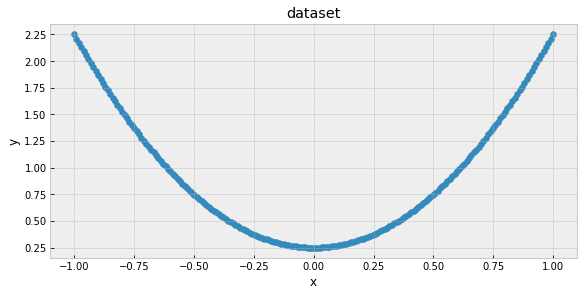

In [ ]:
X = np.linspace(-1, 1, 200)
X = np.array([X**2, X, np.ones(len(X))*.5]).T
w = np.array([2, 0, .5])
y = X @ w

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
ax.scatter(X[:,-2], y)
ax.set(xlabel='x', ylabel='y', title='dataset')
plt.show()

In [ ]:
model_type = 'linear_regression'
model_kwargs = {}
estimator = RegressionEstimator(model_type, model_kwargs)
estimator.fit(X, y)
ate = estimator.estimate_effect(X=X, ix=0, treatment=1, control=0)
print(f'ate = {ate:.3f} coefs {estimator.m.coef_}')

ate = 2.000 coefs [ 2.00000000e+00 -1.27928927e-17  0.00000000e+00]


In [ ]:
#hide
assert np.isclose(ate, w[0], atol=.1)

Generating data for the graphical model using `bcg.basics` functions

In [ ]:
from bcg.basics import CommonCauses, Instruments, EffectModifiers, Treatments, Outcomes, get_Xy
import pandas as pd

In [ ]:
outcome_is_binary = False

n = 333
n_common_causes = len(common_causes)
n_instruments = len(instruments)
n_eff_mods = len(effect_modifiers)
n_treatments = len(treatments)
beta = 1  # max random value

cc = CommonCauses.get_obs(n, n_common_causes)
ins = Instruments.get_obs(n, n_instruments)
em = EffectModifiers.get_obs(n, n_eff_mods)
treat = Treatments.get_obs(n, n_treatments, cc, ins, beta)
out = Outcomes.get_obs(treat, cc, em, outcome_is_binary=outcome_is_binary)
obs = pd.concat((treat.obs, cc.obs, em.obs, ins.obs, out.obs), axis=1)
X, y, not_target = get_Xy(obs, target=outcome)

In [ ]:
not_target.index('V0')

Adding effect estimate functionality to `CausalModel`

In [ ]:
#export
def estimate_effect(self, estimands:dict, control_value:float, 
                    treatment_name:str, treatment_value:float, 
                    obs:pd.DataFrame, outcome:str='Y',
                    causal_method:str='backdoor',
                    model_type:str='linear_regression', target_unit:str='ate', 
                    effect_modifiers:List[str]=None,
                    model_params:dict=None):
    assert causal_method in {'backdoor', 'instrumental_variable'}
    assert model_type == 'linear_regression'
    assert target_unit == 'ate'
    # model_type: linear regression, ...
    
    if effect_modifiers is None:
        effect_modifiers = self.effect_modifiers
            
    # decide on approach given causal_method and model_type
    
    # estimate the effect using the arrived on approach
    X, y, not_outcome = get_Xy(obs, target=outcome)
    estimator = RegressionEstimator(model_type, model_params)
    estimator.fit(X, y)
    ix = [v.lower() for v in not_outcome].index(treatment_name)
    effect = estimator.estimate_effect(X=X, ix=ix, treatment=treatment_value, control=control_value)
    return effect


CausalModel.estimate_effect = estimate_effect

In [ ]:
causal_method = 'backdoor'
model_type = 'linear_regression'
model_params = dict()
control_value = 0
treatment_name = 'v0'
treatment_value = 1
effect_modifiers = effect_modifiers
target_unit = 'ate'
cm.estimate_effect(estimands, control_value, treatment_name, treatment_value,
                   obs, outcome=outcome, causal_method=causal_method, model_type=model_type,
                   target_unit=target_unit, effect_modifiers=effect_modifiers,
                   model_params=model_params)